In [35]:
from scipy import sparse
from scipy.spatial import cKDTree

import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage import color
from skimage import img_as_float

from bridson import poisson_disc_samples

%matplotlib inline


def cartesian_prod(x, y):
    return np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])


class Voronoized:
    
    def __init__(self, image, density, rng='poisson_disc'):
        self.original = image
        self.density = density
        self.rng = rng
        self.transformed = None
        self.voronoize()
    
    def voronoize(self, density=None):
        if density is None:
            density = self.density
        assert(density > 0)

        nx, ny = self.original.shape[:2]
                # make a grid of coords
        x = np.arange(nx)
        y = np.arange(ny)
        coords = cartesian_prod(x, y)
        
        # samples points evenly but not on a grid
        # https://bost.ocks.org/mike/algorithms/
        if self.rng == 'poisson_disc':
            radius = min(nx, ny) / density
            pts = np.asarray(poisson_disc_samples(nx, ny, radius))
        elif self.rng == 'pseudo':
            mask = np.random.randint(len(coords), size=density**2)
            pts = coords[mask]
            
        # https://stackoverflow.com/questions/45883314/python-check-and-count-how-many-where-points-sit-within-voronoi-cells
        voronoi_kdtree = cKDTree(pts)


        # c_regions is an array mapping coords -> voronoi region #
        _, c_regions = voronoi_kdtree.query(coords)


        # copy image size
        self.transformed = np.zeros_like(self.original)

        for r in np.unique(c_regions):
            # mask for coords only in this voronoi region
            mask = np.where(c_regions == r)[0]

            # get the coords and create a mask for the copied image
            row = coords[mask][:, 0]
            col = coords[mask][:, 1]
            data = np.ones_like(row)
            # This is a fast way to go from coords -> mask
            im_mask = sparse.coo_matrix((data, (row, col)), 
                                        shape=self.transformed.shape[:2], 
                                        dtype=bool).toarray()

            # set the value of copied image at coords within this voronoi cell
            # to be the average of the colors in the original in the cell. 
            self.transformed[im_mask] = np.average(self.original[im_mask], axis=0)
        return self.transformed
    
    def show(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

        ax1.axis('off')
        ax1.set_title('Original')
        ax1.imshow(self.original)

        ax2.imshow(self.transformed)
        ax2.axis('off')
        ax2.set_title('Voronoized')
        
        return fig, (ax1, ax2)
    


In [241]:
v = Voronoized(plt.imread('/home/evan/Downloads/us.jpg'), rng='pseudo', density=50)

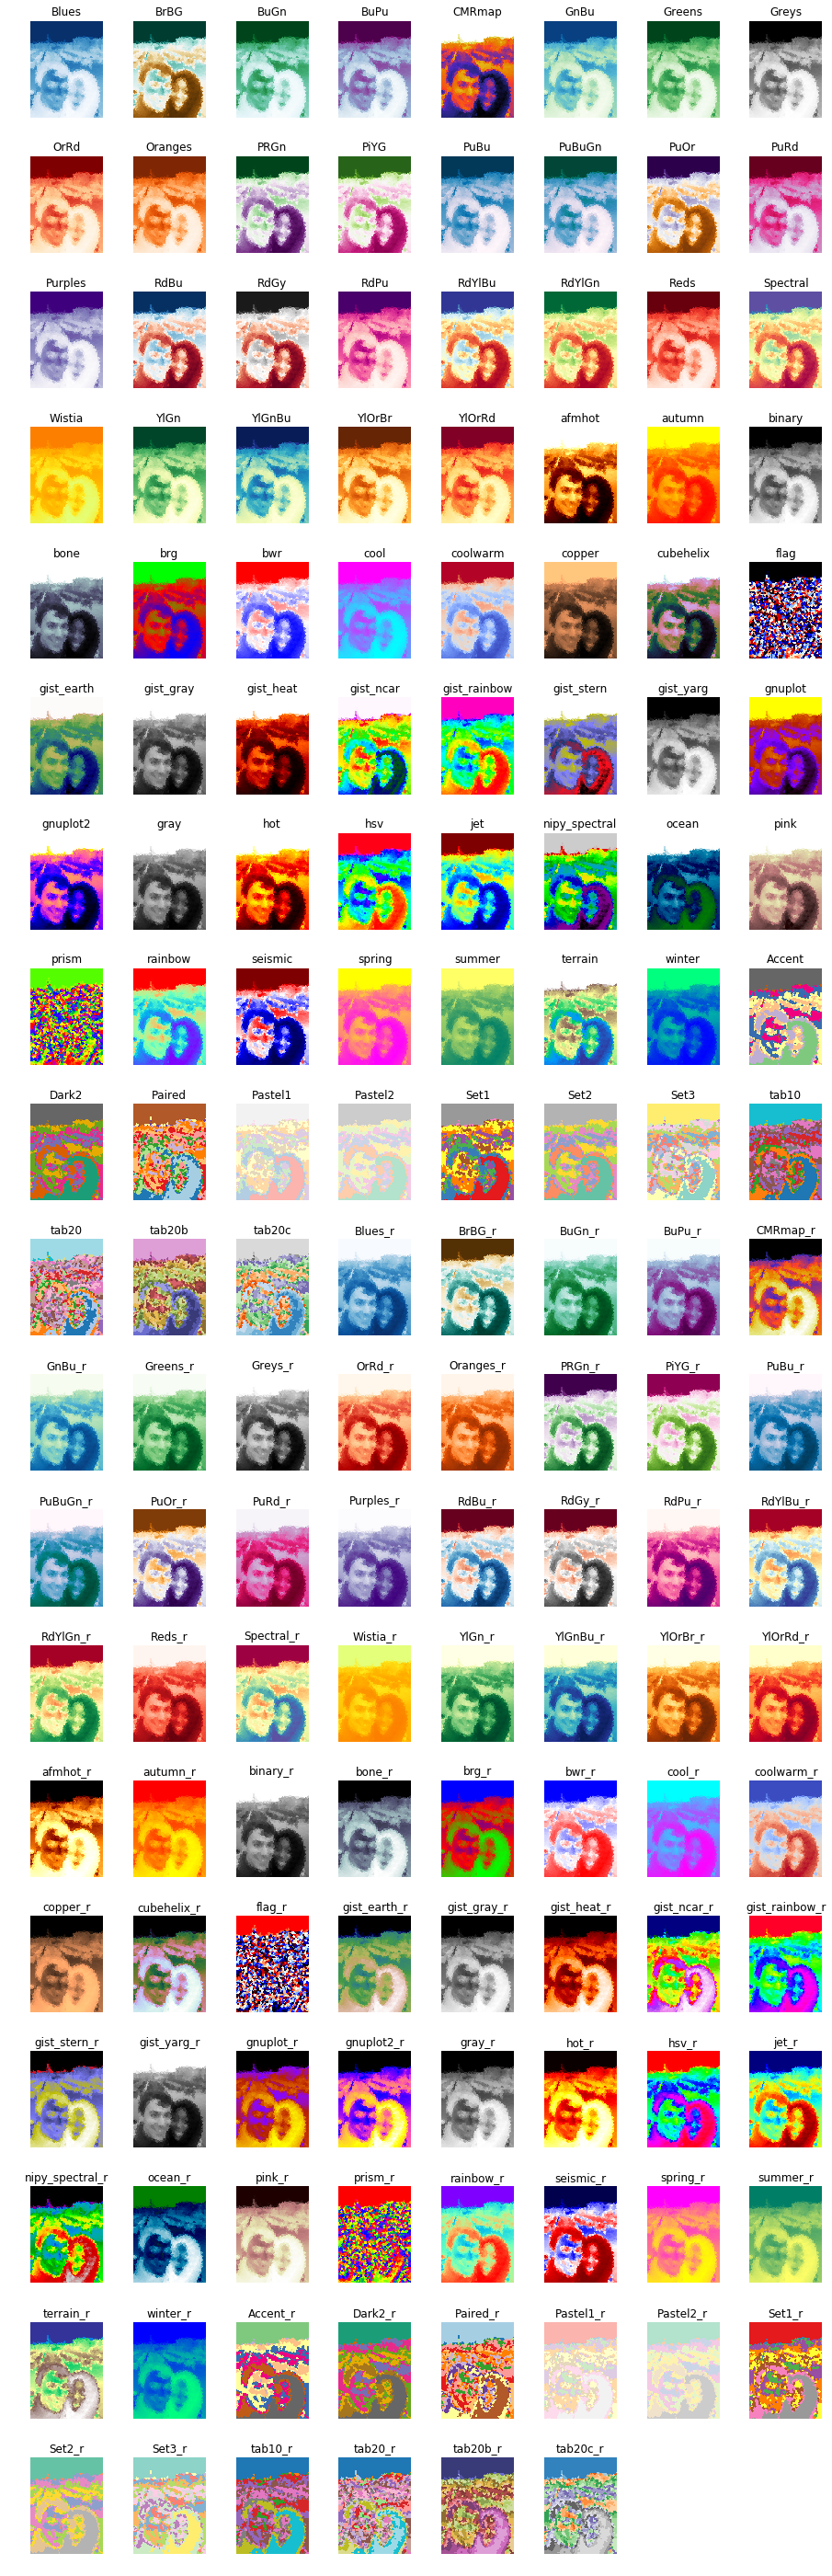

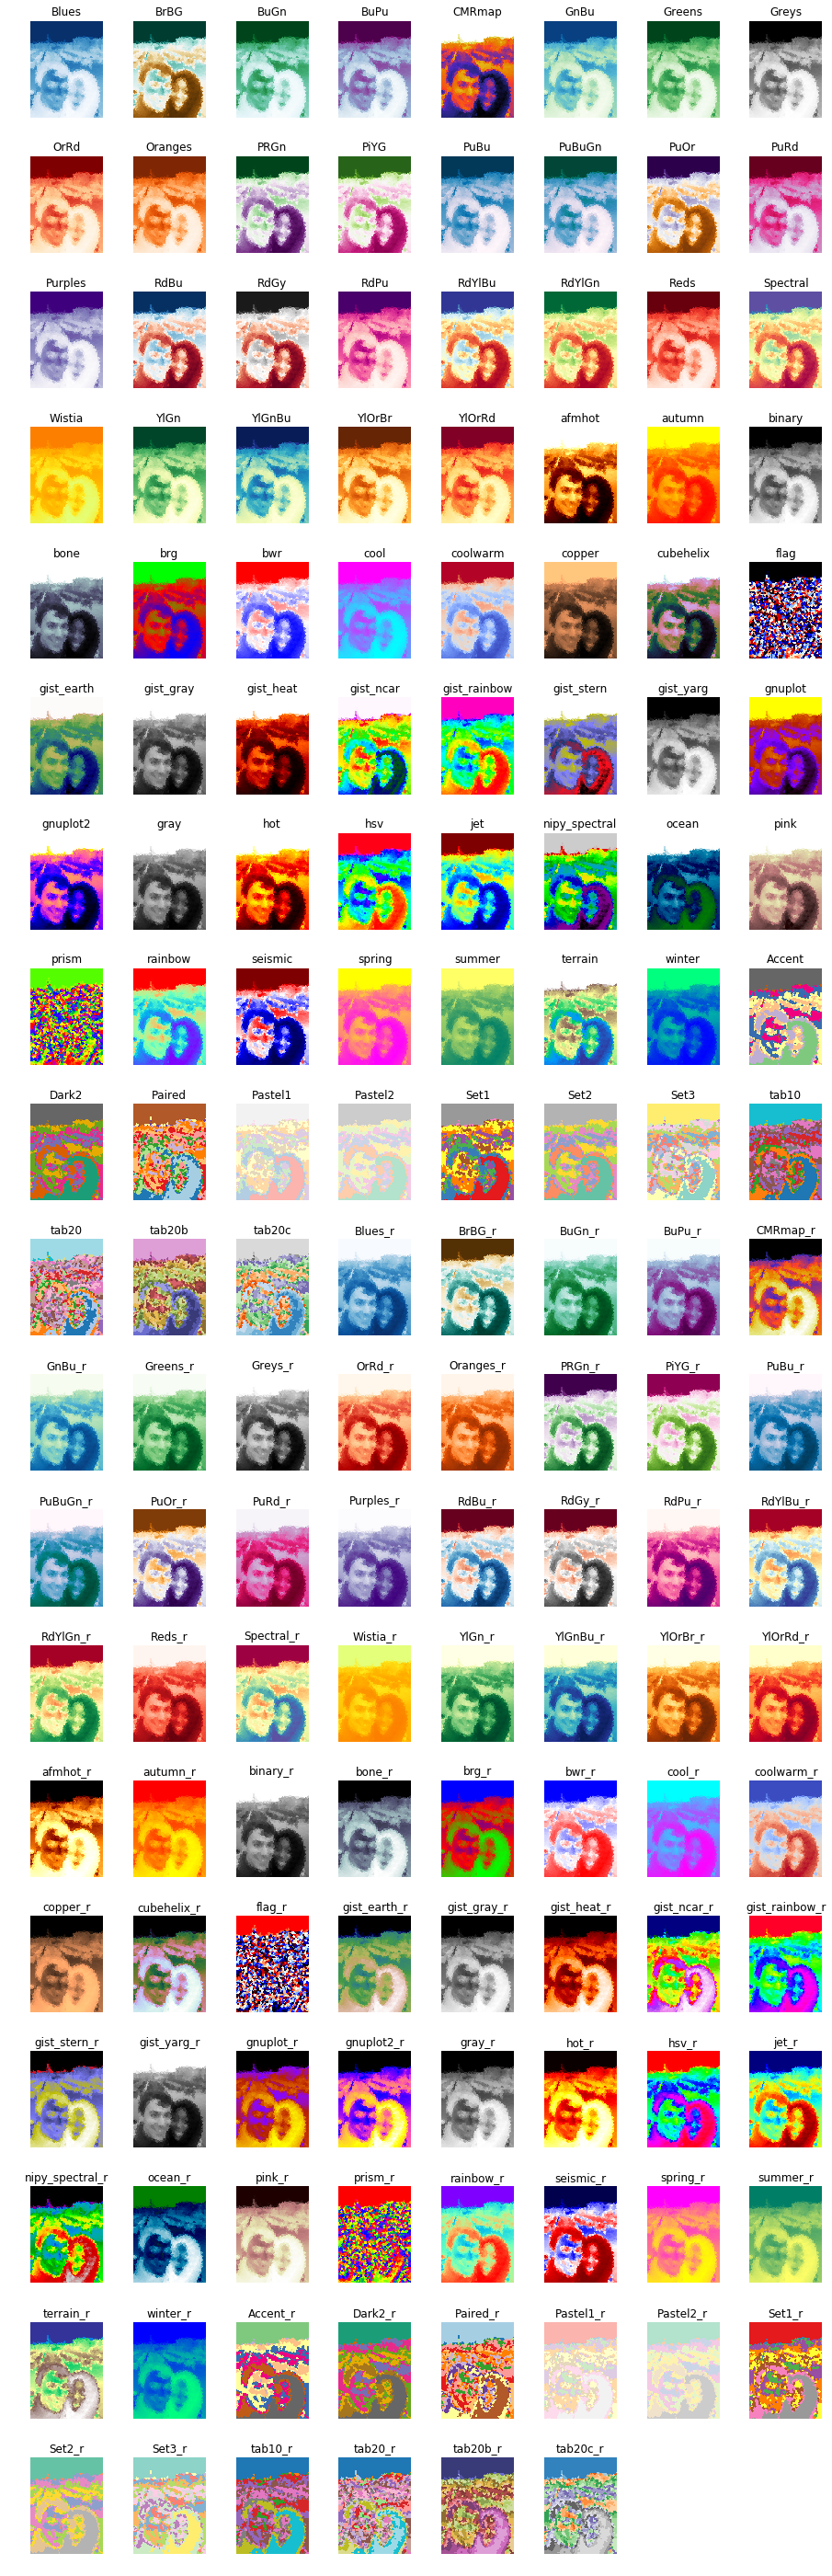

In [242]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

cmaps = [c for c in plt.cm.datad.keys() if not c.endswith('_r')]
cmaps = cmaps + [c + '_r' for c in cmaps]

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def imshow_all_cmaps(image):
    N = len(cmaps)
    n_cols = 8
    n_rows = N // n_cols + 1

    x, y = image.shape[:2]

    ratio = x / y

    fig = plt.figure(figsize=(n_cols*2 , n_rows * ratio*2))
    gs = gridspec.GridSpec(n_rows, n_cols)
    gs.update(wspace=0.01, hspace=0.4) 

    for i, c in enumerate(cmaps):
        ax = plt.subplot(gs[i])
        ax.axis('off')
        ax.set_title(c)
        ax.imshow(rgb2gray(image), cmap=c)
    return fig

imshow_all_cmaps(v.transformed)

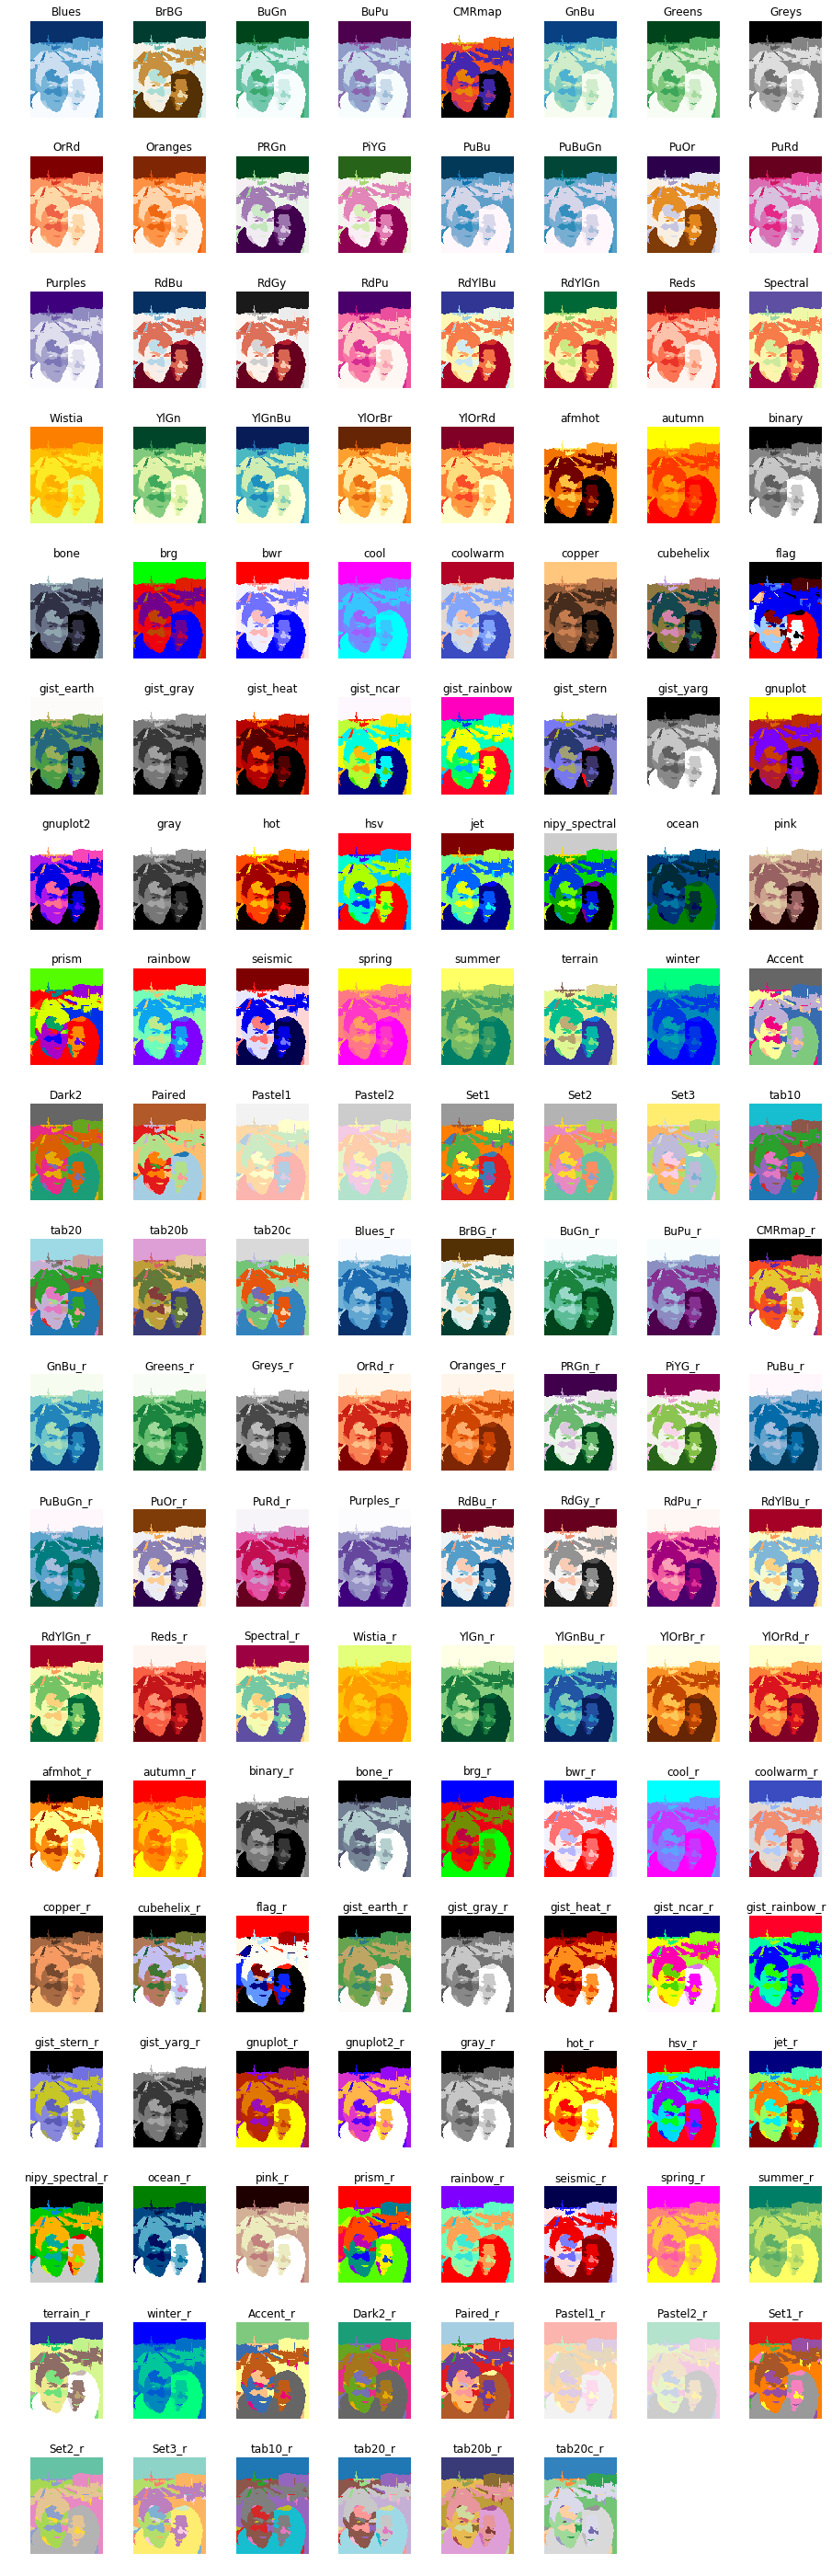

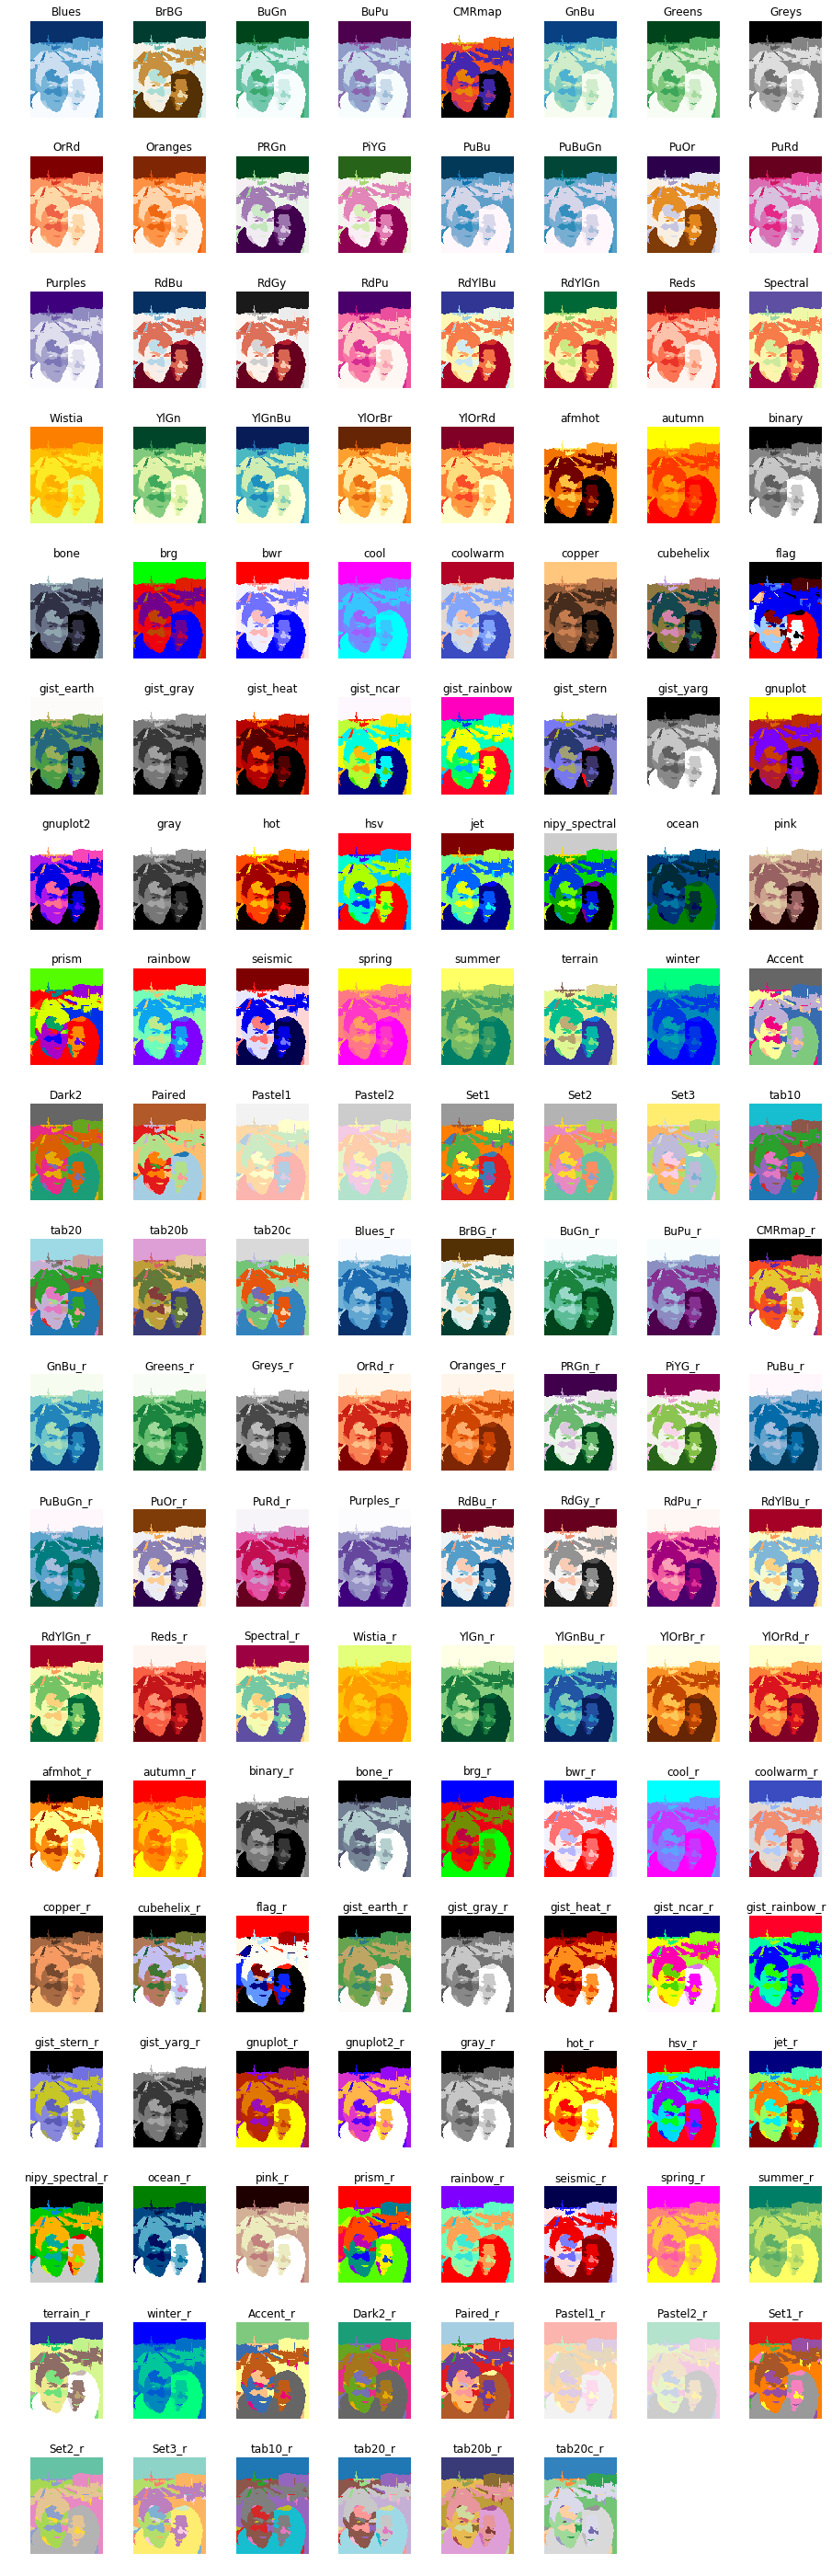

In [243]:
img = v.original

labels1 = segmentation.quickshift(img)

g = graph.rag_mean_color(img, labels1)
labels2 = graph.cut_threshold(labels1, g, 29)
out = color.label2rgb(labels2, img, kind='avg')
imshow_all_cmaps(out)